Available columns: ['patient id', 'gender', 'age', 'pathology', 'ejection fraction (%)', 'end-diastolic volume (ml)', 'end-systolic volume (ml)', 'surface area at ed (cm²)', 'surface area at es (cm²)', 'lv diameter at ed (mm)', 'lv diameter at es (mm)']

Data summary after conversion:
       ejection fraction (%)  end-diastolic volume (ml)  \
count              43.000000                  43.000000   
mean               50.879162                 240.608355   
std                22.236931                 122.743764   
min                10.014812                  76.137107   
25%                31.928597                 148.690448   
50%                50.361064                 200.623660   
75%                66.003541                 333.486342   
max                96.533829                 594.493949   

       end-systolic volume (ml)  
count                 43.000000  
mean                 123.956256  
std                   87.261990  
min                    2.639042  
25%         

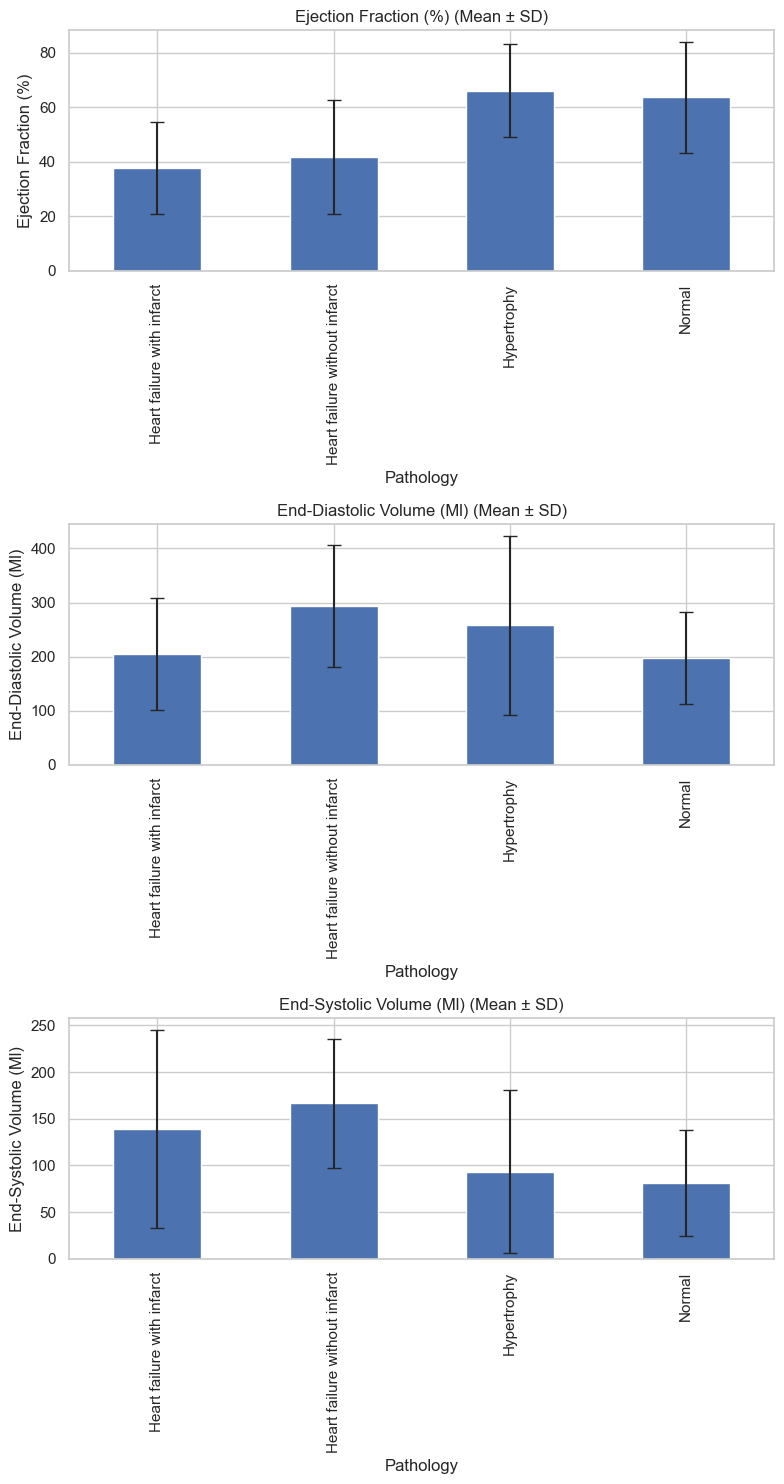

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the data
# For Marching Cubes Analysis
# excel_path = r"C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\Marching_Cubes\patient_metrics_marching_cubes.xlsx"

# For edge detection analysis
excel_path = r"C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\edge_detection_and_contours\patient_metrics_edge_detection.xlsx"
df = pd.read_excel(excel_path)

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Clean the pathology names in the DataFrame and ground truth dictionary
df["pathology"] = df["pathology"].str.strip("[]'")  # Remove [] and quotes from pathology column in DataFrame

# Print all columns for debugging
print("Available columns:", df.columns.tolist())

# Define expected column names (lowercased for matching)
expected_numeric_cols = ["ejection fraction (%)", "end-diastolic volume (ml)", "end-systolic volume (ml)"]

# Verify if expected columns exist
missing_cols = [col for col in expected_numeric_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns: {missing_cols}")

# Convert to numeric and drop NaN values
df[expected_numeric_cols] = df[expected_numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=expected_numeric_cols, inplace=True)

# Print summary for debugging
print("\nData summary after conversion:")
print(df[expected_numeric_cols].describe())

# Ensure 'Pathology' column exists
if "pathology" not in df.columns:
    raise KeyError("Column 'Pathology' not found in the dataset.")

# Group data by pathology and compute mean ± SD
grouped_metrics = df.groupby("pathology")[expected_numeric_cols].agg(['mean', 'std'])

# Print grouped data for debugging
print("\nGrouped Metrics Data:")
print(grouped_metrics)

# Ensure grouped data isn't empty
if grouped_metrics.empty:
    raise ValueError("No valid numerical data found for plotting.")

# Ground truth values
ground_truth = {
    "heart failure with infarct": {
        "ejection fraction (%)": {"mean": 32.01, "std": 12.27}, 
        "end-diastolic volume (ml)": {"mean": 244.92, "std": 86.02}, 
        "end-systolic volume (ml)": {"mean": 174.34, "std": 90.64}
    },
    "heart failure without infarct": {
        "ejection fraction (%)": {"mean": 33.09, "std": 13.07}, 
        "end-diastolic volume (ml)": {"mean": 233.67, "std": 63.21}, 
        "end-systolic volume (ml)": {"mean": 158.28, "std": 56.34}
    },
    "hypertrophy": {
        "ejection fraction (%)": {"mean": 62.72, "std": 9.22}, 
        "end-diastolic volume (ml)": {"mean": 114.39, "std": 50.46}, 
        "end-systolic volume (ml)": {"mean": 43.11, "std": 24.5}
    },
    "normal": {
        "ejection fraction (%)": {"mean": 62.93, "std": 3.65}, 
        "end-diastolic volume (ml)": {"mean": 115.69, "std": 36.89}, 
        "end-systolic volume (ml)": {"mean": 43.1, "std": 14.74}
    }
}

# Plot mean ± SD for each metric per pathology
sns.set_theme(style="whitegrid")


fig, axes = plt.subplots(nrows=len(expected_numeric_cols), figsize=(8, 5 * len(expected_numeric_cols)))

if len(expected_numeric_cols) == 1:
    axes = [axes]

for ax, metric in zip(axes, expected_numeric_cols):
    metric_data = grouped_metrics[metric]
    metric_data.plot(kind='bar', y='mean', yerr='std', capsize=5, ax=ax, legend=False)
    ax.set_title(f"{metric.replace('_', ' ').title()} (Mean ± SD)")
    ax.set_ylabel(metric.title())
    ax.set_xlabel("Pathology")

plt.tight_layout()
plt.show()





Comparing ejection fraction (%):
Pathologies: ['Heart failure with infarct' 'Heart failure without infarct'
 'Hypertrophy' 'Normal']
Observed Means: [np.float64(37.70572669899834), np.float64(41.77469400016167), np.float64(66.1198187072894), np.float64(63.64897019156027)]
Ground Truth Means: [32.01, 33.09, 62.72, 62.93]

Comparing end-diastolic volume (ml):
Pathologies: ['Heart failure with infarct' 'Heart failure without infarct'
 'Hypertrophy' 'Normal']
Observed Means: [np.float64(205.4518674952116), np.float64(294.0410934706063), np.float64(257.78222476033665), np.float64(197.15794488241883)]
Ground Truth Means: [244.92, 233.67, 114.39, 115.69]

Comparing end-systolic volume (ml):
Pathologies: ['Heart failure with infarct' 'Heart failure without infarct'
 'Hypertrophy' 'Normal']
Observed Means: [np.float64(139.1588076907835), np.float64(166.5182250636312), np.float64(93.31756259095991), np.float64(80.9798892122401)]
Ground Truth Means: [174.34, 158.28, 43.11, 43.1]


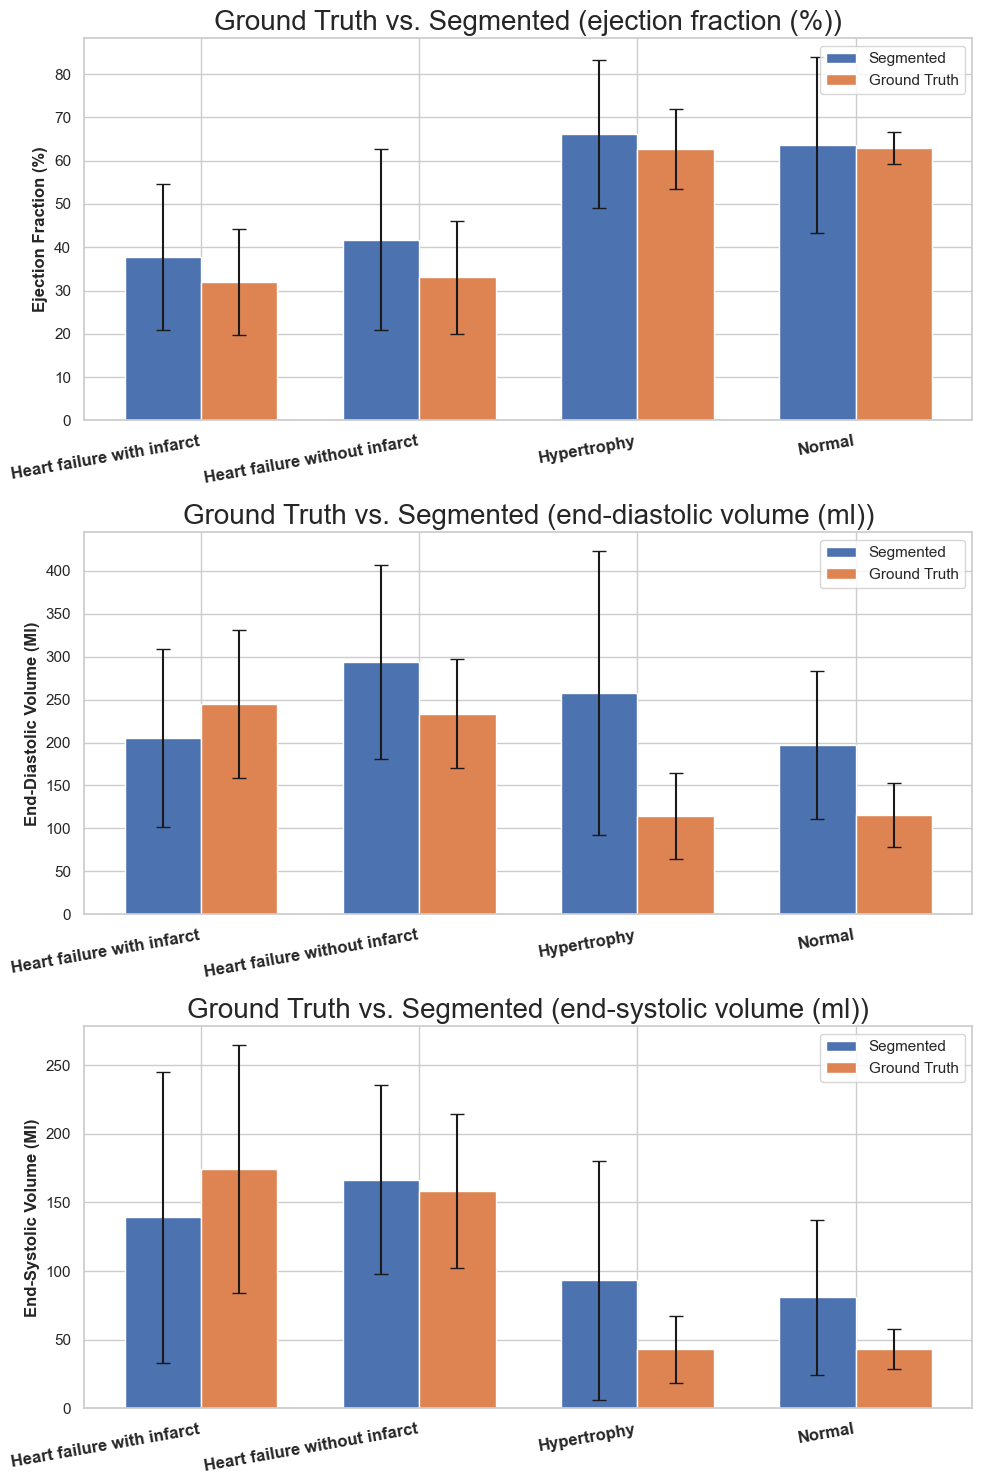

In [46]:
# Clean the pathology names in the DataFrame and ground truth dictionary
df["pathology"] = df["pathology"].str.strip("[]'")  # Remove [] and quotes from pathology column in DataFrame

# Bar plots comparing Ground Truth vs. Segmentation
fig, axes = plt.subplots(nrows=len(expected_numeric_cols), figsize=(10, 5 * len(expected_numeric_cols)))

if len(expected_numeric_cols) == 1:
    axes = [axes]

for ax, metric in zip(axes, expected_numeric_cols):
    pathologies = df["pathology"].unique()

    # Get observed means and standard deviations for each pathology
    observed_means = [df[df["pathology"] == pathology][metric].mean() for pathology in pathologies]
    observed_stds = [df[df["pathology"] == pathology][metric].std() for pathology in pathologies]
    
    # Map ground truth for each pathology by matching substrings
    ground_truth_means = [
        next(
            (ground_truth[key][metric]["mean"] for key in ground_truth if pathology.lower() in key.lower()),
            np.nan
        )
        for pathology in pathologies
    ]
    
    ground_truth_stds = [
        next(
            (ground_truth[key][metric]["std"] for key in ground_truth if pathology.lower() in key.lower()),
            np.nan  # Default value if no match is found
        )
        for pathology in pathologies
    ]

    print(f"\nComparing {metric}:")
    print(f"Pathologies: {pathologies}")
    print(f"Observed Means: {observed_means}")
    print(f"Ground Truth Means: {ground_truth_means}")

    x = np.arange(len(pathologies))
    width = 0.35

    # Plot bars for Segmented and Ground Truth with error bars
    ax.bar(x - width / 2, observed_means, width, yerr=observed_stds, capsize=5, label="Segmented")
    ax.bar(x + width / 2, ground_truth_means, width, yerr=ground_truth_stds, capsize=5, label="Ground Truth")

    ax.set_xticks(x)
    ax.set_xticklabels([pathology.replace("'", "") for pathology in pathologies], rotation=10, ha="right", fontsize=12, fontweight='bold')  # Rotate and adjust label size
    ax.set_title(f"Ground Truth vs. Segmented ({metric})", fontsize=20)
    ax.set_ylabel(metric.title(), fontweight='bold')
    ax.legend()


# Save the figure
save_path = os.path.dirname(excel_path)
save_filename = "ground_truth_vs_segmented_comparison.png"  # Define the filename
save_filepath = os.path.join(save_path, save_filename)  # Join directory and filename
plt.tight_layout()
plt.savefig(save_filepath)

# Display the plot
plt.tight_layout()
plt.show()



Save analysis - mean and SD to an excel in teh output directory.

In [47]:
# Prepare the analysis results
analysis_results = []

# Bar plots comparing Ground Truth vs. Segmentation
for metric in expected_numeric_cols:
    pathologies = df["pathology"].unique()

    # Get observed means and standard deviations for each pathology
    observed_means = [df[df["pathology"] == pathology][metric].mean() for pathology in pathologies]
    observed_stds = [df[df["pathology"] == pathology][metric].std() for pathology in pathologies]
    
    # Map ground truth for each pathology by matching substrings
    ground_truth_means = [
        next(
            (ground_truth[key][metric]["mean"] for key in ground_truth if pathology.lower() in key.lower()),
            np.nan
        )
        for pathology in pathologies
    ]
    
    # Map ground truth standard deviations for each pathology by matching substrings
    ground_truth_stds = [
        next(
            (ground_truth[key][metric]["std"] for key in ground_truth if pathology.lower() in key.lower()),
            np.nan
        )
        for pathology in pathologies
    ]
    
    # Compute percent differences
    percent_diff = [
        (abs(observed_mean - truth_mean) / truth_mean) * 100 if not np.isnan(truth_mean) else np.nan
        for observed_mean, truth_mean in zip(observed_means, ground_truth_means)
    ]
    
    # Collect the data for this metric
    for pathology, observed_mean, observed_std, truth_mean, truth_std, pdiff in zip(
            pathologies, observed_means, observed_stds, ground_truth_means, ground_truth_stds, percent_diff):
        analysis_results.append({
            "Pathology": pathology,
            "Metric": metric,
            "Observed Mean": observed_mean,
            "Observed Std": observed_std,
            "Ground Truth Mean": truth_mean,
            "Ground Truth Std": truth_std,
            "Percent Difference": pdiff
        })

# Convert results to DataFrame
analysis_df = pd.DataFrame(analysis_results)

# Save the analysis data to an Excel file in the same directory as the input file
analysis_filename = "analysis_results.xlsx"
analysis_filepath = os.path.join(save_path, analysis_filename)
analysis_df.to_excel(analysis_filepath, index=False)

print(f"Analysis results saved to {analysis_filepath}")

Analysis results saved to C:\Users\Kaiwen Liu\OneDrive - University of Toronto\Desktop\github_repo\heart_cardiac_mri_image_processing\edge_detection_and_contours\analysis_results.xlsx


Mahri: analysis of ejection fraction results from Kaiwen

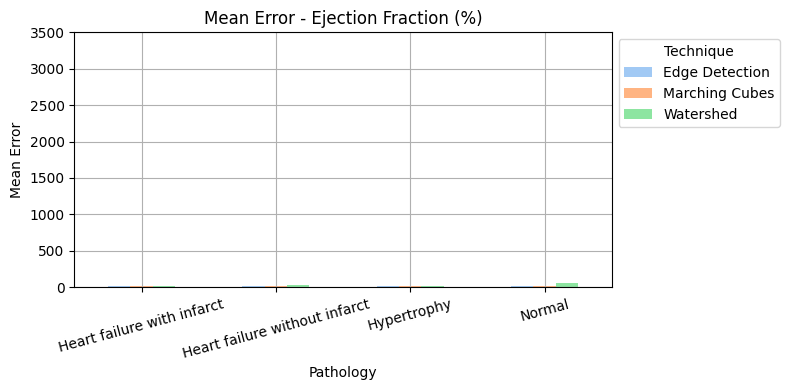

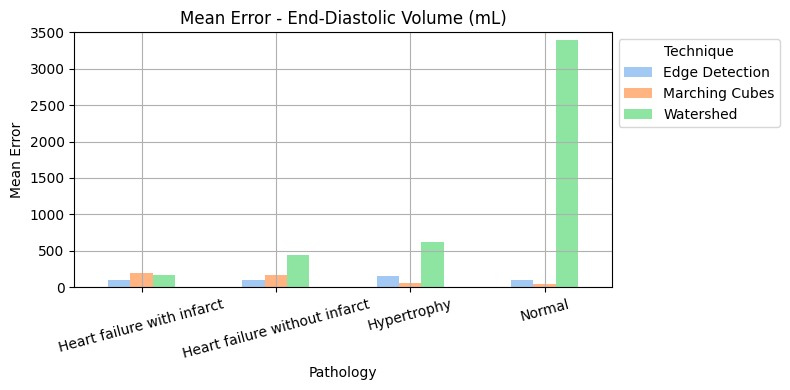

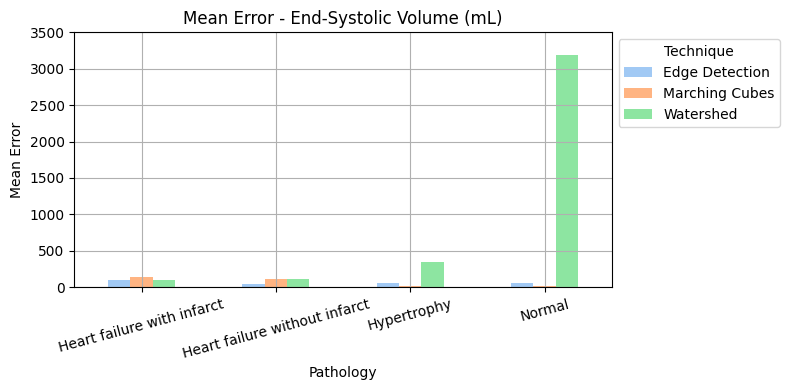

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ground truth values (mean, std) for different pathologies
ground_truth = {
    "Heart failure with infarct": {
        "Ejection Fraction (%)": {"mean": 32.01, "std": 12.27}, 
        "End-Diastolic Volume (mL)": {"mean": 244.92, "std": 86.02}, 
        "End-Systolic Volume (mL)": {"mean": 174.34, "std": 90.64}
    },
    "Heart failure without infarct": {
        "Ejection Fraction (%)": {"mean": 33.09, "std": 13.07}, 
        "End-Diastolic Volume (mL)": {"mean": 233.67, "std": 63.21}, 
        "End-Systolic Volume (mL)": {"mean": 158.28, "std": 56.34}
    },
    "Hypertrophy": {
        "Ejection Fraction (%)": {"mean": 62.72, "std": 9.22}, 
        "End-Diastolic Volume (mL)": {"mean": 114.39, "std": 50.46}, 
        "End-Systolic Volume (mL)": {"mean": 43.11, "std": 24.5}
    },
    "Normal": {
        "Ejection Fraction (%)": {"mean": 62.93, "std": 3.65}, 
        "End-Diastolic Volume (mL)": {"mean": 115.69, "std": 36.89}, 
        "End-Systolic Volume (mL)": {"mean": 43.1, "std": 14.74}
    }
}

# File paths for the three techniques
files = {
    "Marching Cubes": r"C:\Users\mkkad\Desktop\github_repos\heart_cardiac_mri_image_processing\edge_detection_and_contours\ejection_fraction_patient_metrics_marching_cubes.xlsx",
    "Watershed": r"C:\Users\mkkad\Desktop\github_repos\heart_cardiac_mri_image_processing\edge_detection_and_contours\ejection_fraction_patient_metrics_watershed.xlsx",
    "Edge Detection": r"C:\Users\mkkad\Desktop\github_repos\heart_cardiac_mri_image_processing\edge_detection_and_contours\ejection_fraction_patient_metrics_edge_detection.xlsx"
}

# Load and compare results
def compare_results(files, ground_truth):
    results = []

    for technique, file in files.items():
        df = pd.read_excel(file)

        # Loop through each pathology group
        for pathology, metrics in ground_truth.items():
            # Filter data for the given pathology
            pathology_data = df[df["Pathology"] == pathology]
            
            # Calculate the error for each metric
            for metric, values in metrics.items():
                ground_mean = values["mean"]
                ground_std = values["std"]
                
                # For each metric, compare the technique's results to the ground truth
                technique_values = pathology_data[metric].values
                mean_error = np.mean(np.abs(technique_values - ground_mean))
                std_error = np.std(technique_values)

                # Append results to the list
                results.append({
                    "Technique": technique,
                    "Pathology": pathology,
                    "Metric": metric,
                    "Mean Error": mean_error,
                    "Std Error": std_error
                })
    
    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results)
    
    # Save the DataFrame to an Excel file
    results_df.to_excel(r"comparison_results.xlsx", index=False)
    
    return results_df

# Call the function and get the results
comparison_results_df = compare_results(files, ground_truth)

# Plot the results separately for each metric and save each plot with transparent background
def plot_comparison(results_df):
    # Create a plot for each metric
    metrics = results_df["Metric"].unique()

    # Get the pastel color palette from seaborn
    pastel_colors = sns.color_palette("pastel", len(files))

    for metric in metrics:
        fig, ax = plt.subplots(figsize=(8, 4))  # Create a new figure for each plot
        metric_data = results_df[results_df["Metric"] == metric]
        
        # Plot mean error for each technique and pathology with pastel colors
        pivot_data = metric_data.pivot(index="Pathology", columns="Technique", values="Mean Error")
        pivot_data.plot(kind='bar', ax=ax, color=pastel_colors)        
        ax.set_title(f"Mean Error - {metric}")
        ax.set_ylabel("Mean Error")
        ax.set_ylim(0, 3500)
        ax.legend(title="Technique", loc='upper left', bbox_to_anchor=(1, 1))

        # Rotate x-axis labels by 15 degrees
        plt.xticks(rotation=15)
        plt.grid()

        # Adjust the layout so that labels and titles do not overlap
        plt.tight_layout()

        # Save the plot with a transparent background
        plt.savefig(f"{metric}_comparison.png", transparent=True)

        plt.show()  # Show the current plot separately

# Plot the comparison results and save each plot
plot_comparison(comparison_results_df)
